# Train a new model

In this notebook we will learn how to train a new model for axon & myelin segmentation. It covers the following scenario:

* Train a model from scratch by defining the parameters of the network
* Make inference using the trained model

**Important:** If you have access to a GPU card, we strongly recommend you use it. To do so, TensorFlow needs to be uninstalled and then re-installed using the GPU mode:
```bash
source activate ads_venv  # Activate virtual environment. This line might depend on your ADS installation
pip uninstall tensorflow
pip install tensorflow-gpu==1.13.1
```

In [1]:
import os
import json
import time
from pathlib import Path
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util import Retry

# Scientific package imports
import imageio
import numpy as np
import tensorflow as tf
from skimage import io
import matplotlib.pyplot as plt

# Utils import
from shutil import copy
import zipfile
from tqdm import tqdm
import cgi
import tempfile

# AxonDeepSeg imports
try:
    from AxonDeepSeg.ads_utils import download_data
except ModuleNotFoundError:
    # Change cwd to project main folder 
    os.chdir("..")
    try :
        from AxonDeepSeg.ads_utils import download_data
    except:
        raise
except:
    raise
# If no exceptions were raised import all folders        
from AxonDeepSeg.config_tools import validate_config
from AxonDeepSeg.train_network import train_model
from AxonDeepSeg.apply_model import axon_segmentation
import AxonDeepSeg.ads_utils as ads

# reset the tensorflow graph for new training
tf.reset_default_graph()

%matplotlib inline

Using TensorFlow backend.


### 0. Download example data

Before running this notebook, please make sure you have split, patched, and organized your data in the correct way by running the [guide_dataset_building.ipynb](guide_dataset_building.ipynb) tutorial.

### 1. Train a new model
#### 1.1. Define the name and path of the training set

Here we assume that the training data folder has already been created by following the guidelines detailed in [guide_dataset_building.ipynb](https://github.com/neuropoly/axondeepseg/blob/master/notebooks/guide_dataset_building.ipynb).

The expected structure of the training data folder is the following:

~~~
data
 └── Train
      └── image_0.png
      └── mask_0.png
      └── image_1.png
      └── mask_1.png
          ...
 └── Validation
      └── image_0.png
      └── mask_0.png
      └── image_1.png
      └── mask_1.png
          ...
~~~

In [2]:
path_training = Path("./training")  #  folder containing training data

#### 1.2. Define the U-Net architecture and hyper-parameters

Here we defined the network and training parameters (i.e. hyperparameters). We use a lighter network than the ones used in the original [AxonDeepSeg article](https://www.nature.com/articles/s41598-018-22181-4), because they require large GPU memory (>12GB). The network below runs on an NVIDIA TitanX in ~2h. Note that the architecture below might not produce satisfactory results on your data so you likely need to play around with the architecture and hyperparameters.

**Important:** The pixel size is not defined at the training step. During inference however, the parameter `-t {SEM,TEM}` sets the resampling resolution to 0.1µm or 0.01µm respectively (i.e., implying the pixel size of the training data should be around 0.1µm for SEM and 0.01µm for TEM). This is definitely a limitation of the current version of AxonDeepSeg, which we are planning to solve at some point (for more info, see [Issue #152](https://github.com/neuropoly/axondeepseg/issues/152)). 

**Note about data augmentation:**
For each type of data augmentation, the order needs to be specified if you decide to apply more than one transformation sequentially. For instance, setting `da-0-shifting-activate` to `True` means that the shifting is the first transformation that will be applied to the sample(s) during training. The default ranges of transformations are:
- **Shifing**: Random horizontal and vertical shifting between 0 and 10% of the patch size, sampled from a uniform distribution.
- **Rotation**: Random rotation, angle between 5 and 89 degrees, sampled from a uniform distribution.
- **Rescaling**: Random rescaling of a randomly sampled factor between 1/1.2 and 1.2.
- **Flipping**: Random fipping: vertical fipping or horizontal fipping.
- **Blurring**: Gaussian blur with the standard deviation of the gaussian kernel being uniformly sampled between 0 and 4.
- **Elastic deformation**: Random elastic deformation with uniformly sampled deformation coefficient α=[1–8] and fixed standard deviation σ=4.

You can find more information about the range of transformations applied to the patches for each data augmentation technique in the file [data_augmentation.py](https://github.com/neuropoly/axondeepseg/blob/master/AxonDeepSeg/data_management/data_augmentation.py).

In [3]:
# Example of network configuration for TEM data (small network trainable on a Titan X GPU card)
config = {
    
# General parameters:    
  "n_classes": 3,  # Number of classes. For this application, the number of classes should be set to **3** (i.e. axon pixel, myelin pixel, or background pixel).
  "thresholds": [0, 0.2, 0.8],  # Thresholds for the 3-class classification problem. Do not modify.  
  "trainingset_patchsize": 512,  # Patch size of the training set in pixels (note that the patches have the same size in both dimensions).  
  "trainingset": "SEM_3c_512",  # Name of the training set.
  "batch_size": 8,  # Batch size, i.e. the number of training patches used in one iteration of the training. Note that a larger batch size will take more memory.
  "epochs":600,

# Network architecture parameters:     
  "depth": 4,  # Depth of the network (i.e. number of blocks of the U-net).
  "convolution_per_layer": [2, 2, 2, 2],  # Number of convolution layers used at each block.
  "size_of_convolutions_per_layer": [[5, 5], [3, 3], [3, 3], [3, 3]],  # Kernel size of each convolution layer of the network.
  "features_per_convolution": [[[1, 16], [16, 16]], [[16, 32], [32, 32]], [[32, 64], [64, 64]], [[64, 128], [128, 128]]],  # Number of features of each convolution layer.
  "downsampling": "convolution",  # Type of downsampling to use in the downsampling layers of the network. Option "maxpooling" for standard max pooling layer or option "convolution" for learned convolutional downsampling.
  "dropout": 0.75,  # Dropout to use for the training. Note: In TensorFlow, the keep probability is used instead. For instance, setting this param. to 0.75 means that 75% of the neurons of the network will be kept (i.e. dropout of 25%).
     
# Learning rate parameters:    
  "learning_rate": 0.01,  # Learning rate to use in the training.  
  "learning_rate_decay_activate": True,  # Set to "True" to use a decay on the learning rate.  
  "learning_rate_decay_period": 24000,  # Period of the learning rate decay, expressed in number of images (samples) seen.
  "learning_rate_decay_type": "polynomial",  # Type of decay to use. An exponential decay will be used by default unless this param. is set to "polynomial" (to use a polynomial decay).
  "learning_rate_decay_rate": 0.99,  # Rate of the decay to use for the exponential decay. This only applies when the user does not set the decay type to "polynomial".
    
# Batch normalization parameters:     
  "batch_norm_activate": True,  # Set to "True" to use batch normalization during the training.
  "batch_norm_decay_decay_activate": True,  # Set to "True" to activate an exponential decay for the batch normalization step of the training.  
  "batch_norm_decay_starting_decay": 0.7,  # The starting decay value for the batch normalization. 
  "batch_norm_decay_ending_decay": 0.9,  # The ending decay value for the batch normalization.
  "batch_norm_decay_decay_period": 16000,  # Period of the batch normalization decay, expressed in number of images (samples) seen.
        
# Weighted cost parameters:    
  "weighted_cost-activate": True,  # Set to "True" to use weights based on the class in the cost function for the training.
  "weighted_cost-balanced_activate": True,  # Set to "True" to use weights in the cost function to correct class imbalance. 
  "weighted_cost-balanced_weights": [1.1, 1, 1.3],  # Values of the weights for the class imbalance. Typically, larger weights are assigned to classes with less pixels to add more penalty in the cost function when there is a misclassification. Order of the classes in the weights list: background, myelin, axon.
  "weighted_cost-boundaries_sigma": 2,  # Set to "True" to add weights to the boundaries (e.g. penalize more when misclassification happens in the axon-myelin interface).
  "weighted_cost-boundaries_activate": False,  # Value to control the distribution of the boundary weights (if activated). 
    
# Data augmentation parameters:
  "da-type": "all",  # Type of data augmentation procedure. Option "all" applies all selected data augmentation transformations sequentially, while option "random" only applies one of the selected transformations (randomly) to the sample(s). List of available data augmentation transformations: 'random_rotation', 'noise_addition', 'elastic', 'shifting', 'rescaling' and 'flipping'. 
  "da-0-shifting-activate": True, 
  "da-1-rescaling-activate": False,
  "da-2-random_rotation-activate": False,  
  "da-3-elastic-activate": True, 
  "da-4-flipping-activate": True, 
  "da-6-reflection_border-activate": False
}


#### 1.3. Define training path and save configuration parameters

Here we define the path where the new model will be saved. It is useful to add date+time in path definition in case multiple training are launched (to avoid conflicts).

The network configuration parameters defined at 1.2. are saved into a .json file in the model folder. This .json file keeps tract of the network and model parameters in a structured way.

In [4]:
# Define path to where the trained model will be saved
dir_name = Path(config["trainingset"] + '_' + time.strftime("%Y-%m-%d") + '_' + time.strftime("%H-%M-%S"))
path_model = "../models" / dir_name

print("This training session's model will be saved in the folder: " + str(path_model.resolve().absolute()))

# Create directory
if not os.path.exists(path_model):
    os.makedirs(path_model)

# Define file name of network configuration
file_config = 'config_network.json'

# Load/Write config file (depending if it already exists or not)
fname_config = os.path.join(path_model, file_config)
if os.path.exists(fname_config):
    with open(fname_config, 'r') as fd:
        config_network = json.loads(fd.read())
else:
    with open(fname_config, 'w') as f:
        json.dump(config, f, indent=2)
    with open(fname_config, 'r') as fd:
        config_network = json.loads(fd.read())

This training session's model will be saved in the folder: /Users/mathieuboudreau/neuropoly/github/axondeepseg/models/SEM_3c_512_2020-02-04_20-29-43


#### 1.4. Launch the training procedure

The training can be launched by calling the *'train_model'* function. After each epoch, the function will display the loss and accuracy of the model. The model is automatically saved at every 5 epochs.

In [5]:
# reset the tensorflow graph for new testing
tf.reset_default_graph()

train_model(str(path_training), str(path_model), config)
# Note: For multi-OS compatibility of this notebook, paths were defined as Path objects from the pathlib module.
# They need to be converted into strings prior to be given as arguments to train_model(), as some old-style string
# concatenation (e.g. "+") are still used in it.
# In your own application, simply defining paths with correct syntax for your OS as strings instead of Path
# objects would be sufficient.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
7/7 [==============================] - 452s 65s/step - loss: 1.1580 - acc: 0.3618 - dice_axon: 0.2821 - dice_myelin: 0.3583 - val_loss: 4.9262 - val_acc: 0.3923 - val_dice_axon: 0.1431 - val_dice_myelin: 0.1619
Epoch 2/5
7/7 [==============================] - 391s 56s/step - loss: 1.0627 - acc: 0.4394 - dice_axon: 0.3164 - dice_myelin: 0.3541 - val_loss: 1.0005 - val_acc: 0.5447 - val_dice_axon: 0.3241 - val_dice_myelin: 0.3513
Epoch 3/5
7/7 [==============================] - 504s 72s/step - loss: 0.9770 - acc: 0.5119 - dice_axon: 0.3209 - dice_myelin: 0.4254 - val_loss: 0.8955 - val_acc: 0.5324 - val_dice_axon: 0.3710 - val_dice_myelin: 0.4287
Epoch 4/5
7/7 [=========

#### 1.5. Monitor the training with Tensorboard

[TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) can be used to monitor the training procedure (loss and accuracy graphs, gradients, activations, identify bugs, etc.). To run TensorBoard, activate ADS virtual environment and run:
```
tensorboard --logdir PATH_MODEL --port 6006
```
where `PATH_MODEL` corresponds to this notebook's `path_model` variable (folder where model is being trained), and `port` is the port number where the TensorBoard local web server will be sent to (e.g., port 6006). Once the command is run, open a web browser with the address:
```
http://localhost:6006/
```

### 2. Test the trained model
#### 2.1. Set the path of the test image to be segmented with the trained model

In [6]:
# Modify the lines below to use your image
path_img = Path("../AxonDeepSeg/data_test")
file_img = "image.png"

#### 2.2. Launch the image segmentation

In [7]:
# In case you want to test the segmentation with a pre-trained model created using this notebook,
# uncomment the line below.
#path_model = Path("../AxonDeepSeg/models/default_SEM_model")

# reset the tensorflow graph for new testing
tf.reset_default_graph()
prediction = axon_segmentation(path_img, file_img, path_model, config_network,  resampled_resolutions=0.1, verbosity_level=3)

Loading acquisitions ...
Rescaling acquisitions to the target resolution ...
Graph construction ...
Beginning inference ...
processing patch 1 of 6
processing patch 2 of 6
processing patch 3 of 6
processing patch 4 of 6
processing patch 5 of 6
processing patch 6 of 6


#### 2.3. Display the resulted segmentation

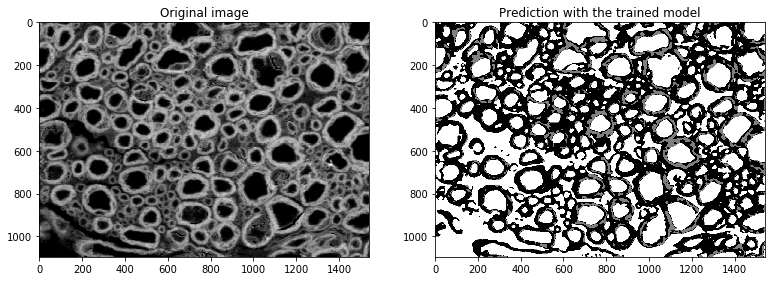

In [8]:
file_img_seg = 'AxonDeepSeg.png'  # axon+myelin segmentation

img_seg = ads.imread(path_img / file_img_seg)
img = ads.imread(path_img / file_img)
# Note: The arguments of the two function calls above use the pathlib syntax for path concatenation.

fig, axes = plt.subplots(1,2, figsize=(13,10))
ax1, ax2 = axes[0], axes[1]
ax1.set_title('Original image')
ax1.imshow(img, cmap='gray')
ax2.set_title('Prediction with the trained model')
ax2.imshow(img_seg,cmap='gray')
plt.show()